In [1]:
import torch

In [4]:
import json
import os.path as osp
import numpy as np

data_path = '/data/liangkongming/code/attribute/KGVA/data/wxr/VAW_Clean_0_1/data'

with open(osp.join(data_path, 'object_index.json')) as f:
    object_index = json.load(f)
    
with open(osp.join(data_path, 'attribute_index.json')) as f:
    attribute_index = json.load(f)

object_index_reversed = {v:k for k, v in object_index.items()}
attribute_index_reversed = {v:k for k, v in attribute_index.items()}

anno = {}
for stage in ['train', 'val', 'test']:
    with open(osp.join(data_path, '{}.json'.format(stage))) as f:
        anno[stage] = json.load(f)

num_obj = len(object_index)
num_att = len(attribute_index)
print(num_obj, num_att)

In [8]:
def calculate_num(anno_list, num_obj, num_att):
    obj_att_anno = np.zeros((num_obj, num_att))
    for anno_image in anno_list:
        object_name = anno_image['object_name']
        positive_attributes = anno_image['positive_attributes']
        negative_attributes = anno_image['negative_attributes']
        object_index_image = object_index[object_name]
        anno_attributes = positive_attributes + negative_attributes
        for att in anno_attributes:
            attribute_index_image = attribute_index[att]
            obj_att_anno[object_index_image, attribute_index_image] += 1
    return obj_att_anno

obj_att_anno = calculate_num(
    anno['train']+anno['val'], num_obj, num_att
)

In [77]:
obj_id = np.random.randint(num_obj)
print('OBJ: ', object_index_reversed[obj_id])

def find_feasible_attribute(obj_att_anno, obj_id):
    att_vec = obj_att_anno[obj_id]
    feasible_attributes = np.where(att_vec > 0)[0]
    feasible_attribute_names = []
    for a in feasible_attributes:
        feasible_attribute_names.append(attribute_index_reversed[a])
    return feasible_attribute_names

feasible_attribute_names = find_feasible_attribute(obj_att_anno, obj_id)
print(feasible_attribute_names)
# for a in feasible_attribute_names:
#     print(attribute_index_reversed[a])

OBJ:  support
['arch shaped', 'black', 'blue', 'circular', 'concrete', 'green', 'mesh', 'metal', 'rounded', 'silver', 'small', 'stone', 'vertical', 'white', 'wooden', 'yellow']


### CLIP

In [84]:
import torch
import clip
from PIL import Image
from glob import glob
import numpy as np
from tqdm import tqdm

In [82]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [128]:
def pred_image(model, anno_image, obj_att_anno=False):
    object_name = anno_image['object_name']
    prompt_template="a photo of "
    if obj_att_anno is False:
        attribute_object_pairs = [prompt_template + x + ' ' + object_name for x in attribute_index]
    else:
        feasible_attributes = find_feasible_attribute(obj_att_anno, object_index[object_name])
        attribute_object_pairs = [prompt_template + x + ' ' + object_name for x in feasible_attributes]
    bbox = anno_image['instance_bbox']
    bbox = list(map(int, bbox))
    image_path = glob('/data/liangkongming/data/VG/*/{}.jpg'.format(anno_image['image_id']))[0]
    image = Image.open(image_path)
    image_crop = image.crop((bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]))
    image = preprocess(image_crop).unsqueeze(0).to(device)
    text = clip.tokenize(attribute_object_pairs).to(device)

    with torch.no_grad():
#         image_features = model.encode_image(image)
#         text_features = model.encode_text(text)
        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    return image_crop, object_name, probs

def find_top_k(input_list, K=5):
    index_list = np.argsort(input_list)[-K::]
    index_list = index_list[::-1]
    return index_list

In [170]:
anno_image.keys()

dict_keys(['image_id', 'instance_id', 'instance_bbox', 'instance_polygon', 'object_name', 'positive_attributes', 'negative_attributes'])

In [179]:
MAX_NUM = 1000
out_anno_train = []
# image_id = np.random.randint(len())
for image_id in tqdm(range(len(anno['train']))):
    anno_image = anno['train'][image_id]
    # print(anno_image['positive_attributes'], anno_image['negative_attributes'])
    image_crop, object_name, probs = pred_image(model, anno_image, obj_att_anno)
    feasible_attributes = find_feasible_attribute(obj_att_anno, object_index[object_name])
    top_attributes = find_top_k(probs[0], K=MAX_NUM)
    top_attributes = [feasible_attributes[x] for x in top_attributes]
    anno_image['candidate_attributes'] = top_attributes
    out_anno_train.append(anno_image)
# print(object_name, len(top_attributes), len(feasible_attributes))
# print(top_attributes[0:5])
# image_crop

In [181]:
out_anno_train[0]['candidate_attributes'][0:5]

['tiled', 'patterned', 'checkered', 'stucco', 'taupe']

In [184]:
output_path = '/data/liangkongming/code/attribute/KGVA/data/wxr/VAW_Clean_0_1/data-nidc'
with open(osp.join(output_path, 'train.json'), 'w') as f:
    json.dump(out_anno_train, f)

concrete ['athletic', 'angry', 'balancing', 'arch shaped', 'baggy']


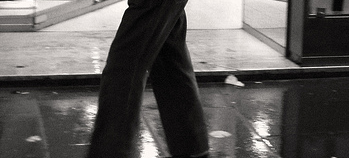

In [159]:
image_id = np.random.randint(len(anno['train']))
anno_image = anno['train'][image_id]
print(anno_image['positive_attributes'], anno_image['negative_attributes'])
image_crop, object_name, probs = pred_image(model, anno_image)
top_attributes = find_top_k(probs[0], K=5)
top_attributes = [attribute_index_reversed[x] for x in top_attributes]
print(object_name, top_attributes)
image_crop